# AutoML

## Setting Up ML Client

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

# üîê Authenticate and connect to Azure ML workspace
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=credential)

# ‚úÖ Confirm connection
print("\n‚úÖ Azure ML Workspace Loaded Successfully\n")
print(f"üîë Subscription ID : {ml_client.subscription_id}")
print(f"üì¶ Resource Group  : {ml_client.resource_group_name}")
print(f"üß† Workspace Name  : {ml_client.workspace_name}\n")

Found the config file in: /config.json



‚úÖ Azure ML Workspace Loaded Successfully

üîë Subscription ID : 03571d3d-f675-492f-8346-8b04c78ed80f
üì¶ Resource Group  : student-performance-rg
üß† Workspace Name  : student-performance-ws



## Grabbing the Name of the Storage Account

In [2]:
from azure.mgmt.storage import StorageManagementClient

subscription_id = ml_client.subscription_id  
resource_group = ml_client.resource_group_name

storage_client = StorageManagementClient(credential, subscription_id)

# List storage accounts in the resource group
accounts = list(storage_client.storage_accounts.list_by_resource_group(resource_group))

# Check if any accounts exist
if not accounts:
    raise Exception("‚ùå No storage accounts found in this resource group.")

# Grab the first one
storage_account_name = accounts[0].name

# ‚úÖ Optional: print them
print("\nüì¶ Storage Accounts in Resource Group:")
for account in accounts:
    print("‚Ä¢", account.name)

print(f"\n‚úÖ Using storage account named: {storage_account_name}")


üì¶ Storage Accounts in Resource Group:
‚Ä¢ studperfstor

‚úÖ Using storage account named: studperfstor


## Grabbing the Name of the Container with JSON Data

In [3]:
from azure.storage.blob import BlobServiceClient

# Get storage account keys
keys = storage_client.storage_accounts.list_keys(resource_group, storage_account_name)
storage_key = keys.keys[0].value

# Build BlobServiceClient using account name and key
account_url = f"https://{storage_account_name}.blob.core.windows.net"
blob_service_client = BlobServiceClient(account_url=account_url, credential=storage_key)

# List all containers and filter
print("\nüìÅ Blob Containers in the Storage Account (filtered):")
filtered_containers = [
    container.name for container in blob_service_client.list_containers()
    if "insights" not in container.name.lower() and "azureml" not in container.name.lower()
]

if not filtered_containers:
    raise Exception("‚ùå No user-defined containers found (filtered out 'insights' and 'azureml').")

# Grab the first matching container
container_name = filtered_containers[0]

# ‚úÖ Output
for name in filtered_containers:
    print("‚Ä¢", name)

print(f"\n‚úÖ Using container: {container_name}")


üìÅ Blob Containers in the Storage Account (filtered):
‚Ä¢ student-math-project-files

‚úÖ Using container: student-math-project-files


## Locating the Name of the Config File

In [4]:
# Create a ContainerClient for the chosen container
container_client = blob_service_client.get_container_client(container_name)

# Find the first .json blob in the container
config_name = None
print(f"\nüìÑ Files in Container '{container_name}':")

for blob in container_client.list_blobs():
    print("‚Ä¢", blob.name)
    if config_name is None and blob.name.lower().endswith(".json"):
        config_name = blob.name

if not config_name:
    raise Exception("‚ùå No .json file found in this container.")

print(f"\n‚úÖ Using config file: {config_name}")


üìÑ Files in Container 'student-math-project-files':
‚Ä¢ config.json
‚Ä¢ student-mat.csv

‚úÖ Using config file: config.json


## Importing Config Information and Saving It In Memory

In [5]:
import json
from azure.storage.blob import BlobClient

# === Build blob URL and load JSON ===
blob_url = f"https://{storage_account_name}.blob.core.windows.net/{container_name}/{config_name}"
blob_client = BlobClient.from_blob_url(blob_url, credential=credential)

# Download and parse JSON
json_bytes = blob_client.download_blob().readall()
json_data = json.loads(json_bytes)

# === Metadata ===
created_at = json_data["metadata"]["created_at"]
created_year = json_data["metadata"]["created_year"]
created_month = json_data["metadata"]["created_month"]
created_day = json_data["metadata"]["created_day"]
created_time = json_data["metadata"]["created_time"]

# === Azure Info ===
subscription_id = json_data["azure"]["subscription_id"]
resource_group = json_data["azure"]["resource_group"]
location = json_data["azure"]["location"]
storage_account_name = json_data["azure"]["storage_account_name"]
storage_container_uri = json_data["azure"]["storage_container_uri"]
managed_identity_principal_id = json_data["azure"]["managed_identity_principal_id"]
auth_mode = json_data["azure"]["auth_mode"]

# === Workspace Info ===
workspace_name = json_data["workspace"]["workspace_name"]
storage_account_id = json_data["workspace"]["storage_account_id"]
key_vault_id = json_data["workspace"]["key_vault_id"]
app_insights_id = json_data["workspace"]["application_insights_id"]

# === Datastore Info ===
datastore_name = json_data["datastore"]["datastore_name"]
container_name = json_data["datastore"]["container_name"]
blob_name = json_data["datastore"]["blob_name"]

# === Dataset Info ===
dataset_name = json_data["dataset"]["dataset_name"]
dataset_uri = json_data["dataset"]["dataset_uri"]
dataset_version = json_data["dataset"]["dataset_version"]
dataset_description = json_data["dataset"]["dataset_description"]
delimiter = json_data["dataset"]["delimiter"]
encoding = json_data["dataset"]["encoding"]
has_header = json_data["dataset"]["has_header"]

# === Compute Info ===
compute_name = json_data["compute"]["compute_name"]
compute_size = json_data["compute"]["compute_size"]

# === Pretty Print with Emojis ===
print("\nüìÖ Workspace Metadata:")
print(f"  ‚Ä¢ Created At   : {created_at}")
print(f"  ‚Ä¢ Date         : {created_day} {created_month} {created_year}")
print(f"  ‚Ä¢ Time         : {created_time}")

print("\nüîê Azure Configuration:")
print(f"  ‚Ä¢ Subscription ID      : {subscription_id}")
print(f"  ‚Ä¢ Resource Group       : {resource_group}")
print(f"  ‚Ä¢ Location             : {location}")
print(f"  ‚Ä¢ Auth Mode            : {auth_mode}")
print(f"  ‚Ä¢ Managed Identity ID  : {managed_identity_principal_id}")

print("\nüì¶ Storage:")
print(f"  ‚Ä¢ Account Name         : {storage_account_name}")
print(f"  ‚Ä¢ Container URI        : {storage_container_uri}")

print("\nüß† Workspace:")
print(f"  ‚Ä¢ Workspace Name       : {workspace_name}")
print(f"  ‚Ä¢ Storage Account ID   : {storage_account_id}")
print(f"  ‚Ä¢ Key Vault ID         : {key_vault_id}")
print(f"  ‚Ä¢ App Insights ID      : {app_insights_id}")

print("\nüóÉÔ∏è Datastore:")
print(f"  ‚Ä¢ Datastore Name       : {datastore_name}")
print(f"  ‚Ä¢ Container Name       : {container_name}")
print(f"  ‚Ä¢ Blob Name            : {blob_name}")

print("\nüìä Dataset:")
print(f"  ‚Ä¢ Dataset Name         : {dataset_name}")
print(f"  ‚Ä¢ Version              : {dataset_version}")
print(f"  ‚Ä¢ Description          : {dataset_description}")
print(f"  ‚Ä¢ URI                  : {dataset_uri}")
print(f"  ‚Ä¢ Delimiter            : {delimiter}")
print(f"  ‚Ä¢ Encoding             : {encoding}")
print(f"  ‚Ä¢ Has Header           : {has_header}")

print("\nüñ•Ô∏è Compute:")
print(f"  ‚Ä¢ Compute Name         : {compute_name}")
print(f"  ‚Ä¢ Compute Size         : {compute_size}\n")


üìÖ Workspace Metadata:
  ‚Ä¢ Created At   : 2025-04-16T15:36:33+0200
  ‚Ä¢ Date         : 16 April 2025
  ‚Ä¢ Time         : 15:36:33 CEST

üîê Azure Configuration:
  ‚Ä¢ Subscription ID      : 03571d3d-f675-492f-8346-8b04c78ed80f
  ‚Ä¢ Resource Group       : student-performance-rg
  ‚Ä¢ Location             : norwayeast
  ‚Ä¢ Auth Mode            : managed_identity
  ‚Ä¢ Managed Identity ID  : a4d92aeb-6282-4e38-8fbb-69806440a455

üì¶ Storage:
  ‚Ä¢ Account Name         : studperfstor
  ‚Ä¢ Container URI        : https://studperfstor.blob.core.windows.net/student-math-project-files

üß† Workspace:
  ‚Ä¢ Workspace Name       : student-performance-ws
  ‚Ä¢ Storage Account ID   : /subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourceGroups/student-performance-rg/providers/Microsoft.Storage/storageAccounts/studperfstor
  ‚Ä¢ Key Vault ID         : /subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourceGroups/student-performance-rg/providers/Microsoft.KeyVault/vaults/stude

## Importing the Dataset

In [29]:
import pandas as pd
from tabulate import tabulate

print(f"\nüì¶ Fetching dataset '{dataset_name}' (v{dataset_version})...")

try:
    # SDK v2 style: directly fetch the dataset by name & version
    dataset = ml_client.data.get(name=dataset_name, version=dataset_version)

    if not dataset.path:
        print("‚ùå No accessible path found in data asset.")
    else:
        print(f"üìÑ Path: {dataset.path}")
        df = pd.read_csv(dataset.path, delimiter=delimiter, encoding=encoding)

        # Drop 2nd and 3rd last columns
        cols_to_drop = df.columns[-3:-1]
        df.drop(columns=cols_to_drop, inplace=True)

        print("‚úÖ Dataset loaded successfully!")
        print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))   
except Exception as e:
    print("‚ùå Failed to load dataset with pandas.")
    print("Error:", e)


üì¶ Fetching dataset 'student-math' (v1)...
üìÑ Path: azureml://subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourcegroups/student-performance-rg/workspaces/student-performance-ws/datastores/studentmathdatastore/paths/student-mat.csv
‚úÖ Dataset loaded successfully!
‚ïí‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê

## Creating Summary Statistics on the Dataset

In [30]:
from tabulate import tabulate

# Transpose so stats are rows, not columns (optional, for better layout)
summary = df.describe().transpose()

# Print with headers and index
print(tabulate(summary, headers="keys", tablefmt="fancy_grid", showindex=True))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ            ‚îÇ   count ‚îÇ      mean ‚îÇ      std ‚îÇ   min ‚îÇ   25% ‚îÇ   50% ‚îÇ   75% ‚îÇ   max ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ age        ‚îÇ     395 ‚îÇ 16.6962   ‚îÇ 1.27604  ‚îÇ    15 ‚îÇ    16 ‚îÇ    17 ‚îÇ    18 ‚îÇ    22 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

## Distribution of G3 Scores

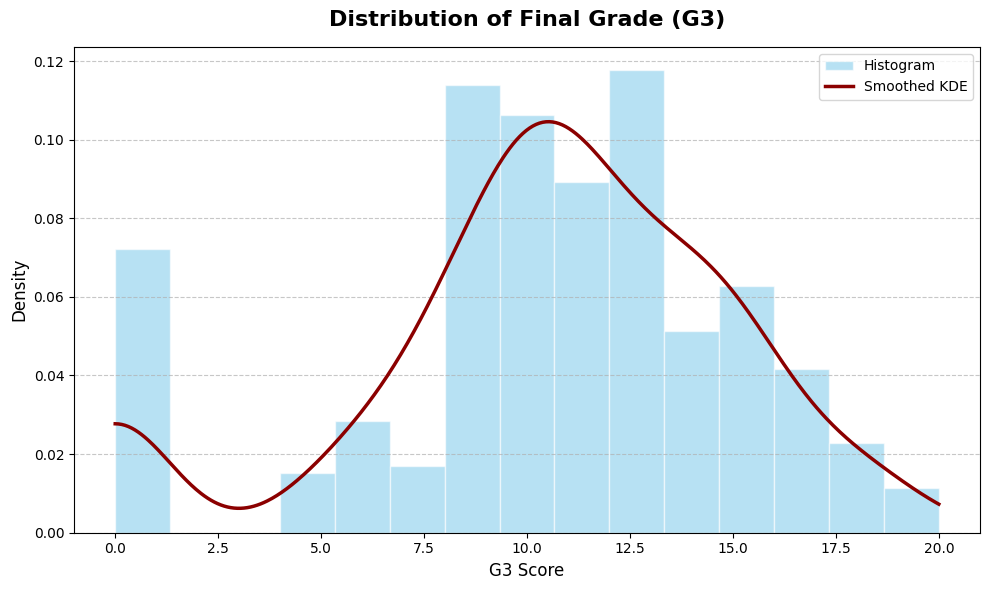


üìä Summary Statistics for G3 (Final Grade):

- Mean:                  10.42
- Median:                11.0
- Mode(s):               10
- Standard Deviation:    4.58
- Min:                   0
- Max:                   20

üìê Distribution Shape:
- Skewness:              -0.730  (Left-skewed)
- Kurtosis:              +0.383  (Leptokurtic)

üìà Percentiles:
- 10th               5.0
- 25th (Q1)          8.0
- 50th (Median)      11.0
- 75th (Q3)          14.0
- 90th               15.600000000000023

üìä Performance Breakdown:
- Above average:         209 students
- Below average:         186 students
- Failing (‚â§ 9):      130
- Perfect score (20):    1

üö® Outliers detected:     0 student(s) using IQR method


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# ‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
# ‚ïë                     üé® G3 HISTOGRAM PLOT                   ‚ïë
# ‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

# Extract G3 column
g3 = df["G3"]

plt.figure(figsize=(10, 6))  # Wider plot

# Plot histogram
counts, bins, patches = plt.hist(
    g3, bins=15, density=True, edgecolor='white', color='skyblue', alpha=0.6, label="Histogram"
)

# Add KDE curve
kde = stats.gaussian_kde(g3)
x = np.linspace(g3.min(), g3.max(), 500)
plt.plot(x, kde(x), color='darkred', linewidth=2.5, label="Smoothed KDE")

# Titles and labels
plt.title("Distribution of Final Grade (G3)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("G3 Score", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Grid & ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Legend
plt.legend()

# Tight layout for spacing
plt.tight_layout()
plt.show()

# ‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
# ‚ïë         üìä STATISTICAL SUMMARY OF G3 DISTRIBUTION          ‚ïë
# ‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

# Basic stats
mean = g3.mean()
median = g3.median()
mode = g3.mode().values
std = g3.std()
min_val = g3.min()
max_val = g3.max()

# Distribution shape
skewness = stats.skew(g3)
kurtosis = stats.kurtosis(g3)

# Percentiles
percentiles = {
    "10th": np.percentile(g3, 10),
    "25th (Q1)": np.percentile(g3, 25),
    "50th (Median)": np.percentile(g3, 50),
    "75th (Q3)": np.percentile(g3, 75),
    "90th": np.percentile(g3, 90),
}

# Counts relative to mean
above_avg = (g3 > mean).sum()
below_avg = (g3 < mean).sum()

# Thresholds
fail_threshold = 9
perfect_score = 20
num_failing = (g3 <= fail_threshold).sum()
num_perfect = (g3 == perfect_score).sum()

# Outlier detection using IQR
Q1 = percentiles["25th (Q1)"]
Q3 = percentiles["75th (Q3)"]
IQR = Q3 - Q1
outliers = g3[(g3 < (Q1 - 1.5 * IQR)) | (g3 > (Q3 + 1.5 * IQR))]

# Display everything
print("\nüìä Summary Statistics for G3 (Final Grade):\n")
print(f"- Mean:                  {mean:.2f}")
print(f"- Median:                {median}")
print(f"- Mode(s):               {', '.join(map(str, mode))}")
print(f"- Standard Deviation:    {std:.2f}")
print(f"- Min:                   {min_val}")
print(f"- Max:                   {max_val}")

print("\nüìê Distribution Shape:")
print(f"- Skewness:              {skewness:+.3f}  ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetrical'})")
print(f"- Kurtosis:              {kurtosis:+.3f}  ({'Leptokurtic' if kurtosis > 0 else 'Platykurtic' if kurtosis < 0 else 'Mesokurtic'})")

print("\nüìà Percentiles:")
for label, value in percentiles.items():
    print(f"- {label:<18} {value}")

print("\nüìä Performance Breakdown:")
print(f"- Above average:         {above_avg} students")
print(f"- Below average:         {below_avg} students")
print(f"- Failing (‚â§ {fail_threshold}):      {num_failing}")
print(f"- Perfect score ({perfect_score}):    {num_perfect}")

print(f"\nüö® Outliers detected:     {len(outliers)} student(s) using IQR method")

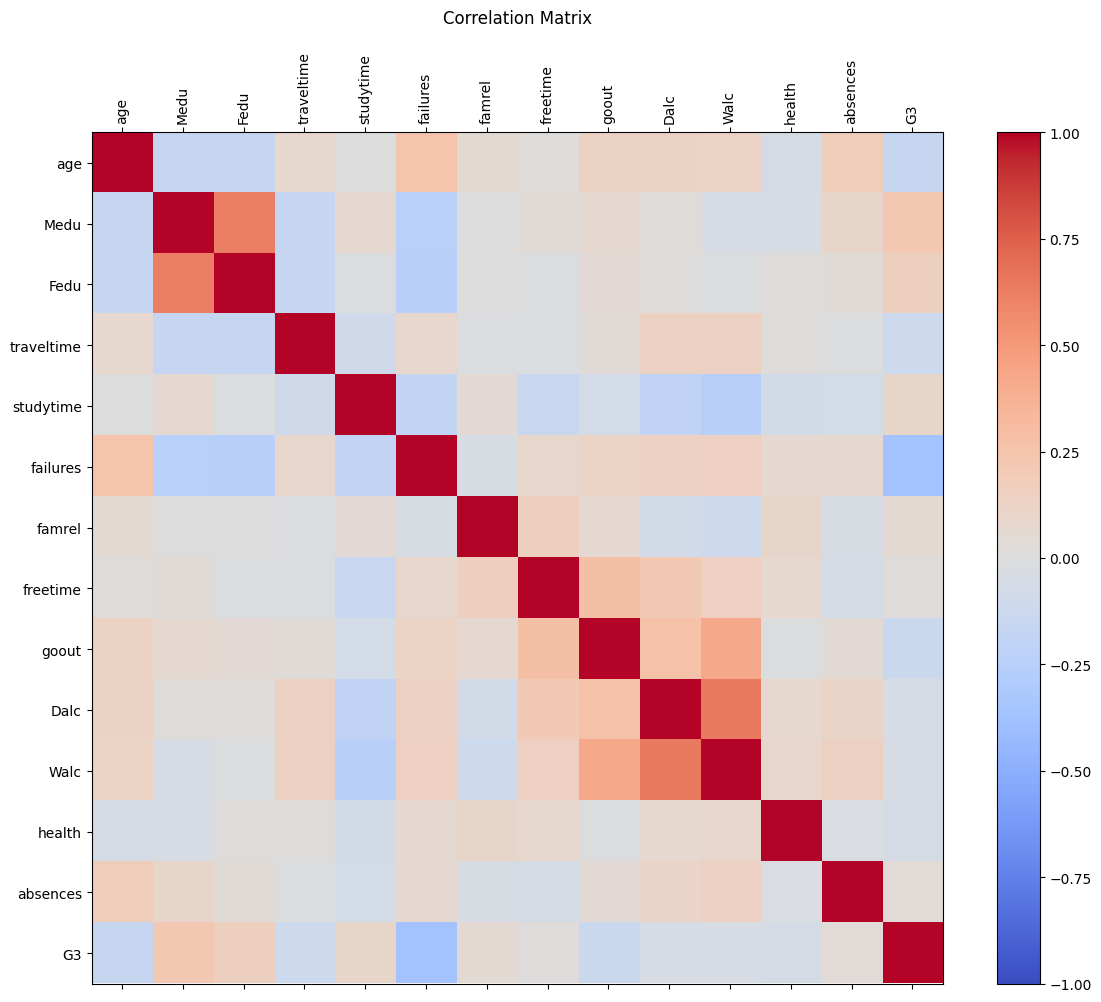


üìä Top 5 variables most correlated with G3:

1. failures        ‚Üí correlation: -0.360
2. Medu            ‚Üí correlation: +0.217
3. age             ‚Üí correlation: -0.162
4. Fedu            ‚Üí correlation: +0.152
5. goout           ‚Üí correlation: -0.133


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# ‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
# ‚ïë               üìå CORRELATION MATRIX VISUALIZATION          ‚ïë
# ‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

# Select only numeric columns manually
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Show matrix
cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(cax)

# Ticks and labels
ticks = np.arange(len(corr.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Improve spacing
plt.title("Correlation Matrix", pad=20)
plt.tight_layout()
plt.show()

# ‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
# ‚ïë        üìä TOP 5 VARIABLES MOST CORRELATED WITH G3          ‚ïë
# ‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

# Get correlation with G3 and drop G3 itself
g3_corr = numeric_df.corr()["G3"].drop("G3")

# Sort by absolute correlation
top_5 = g3_corr.reindex(g3_corr.abs().sort_values(ascending=False).index)[:5]

# Print with numbers
print("\nüìä Top 5 variables most correlated with G3:\n")
for i, (col, val) in enumerate(top_5.items(), start=1):
    print(f"{i}. {col:15s} ‚Üí correlation: {val:+.3f}")

## Box and Whiskers Plots

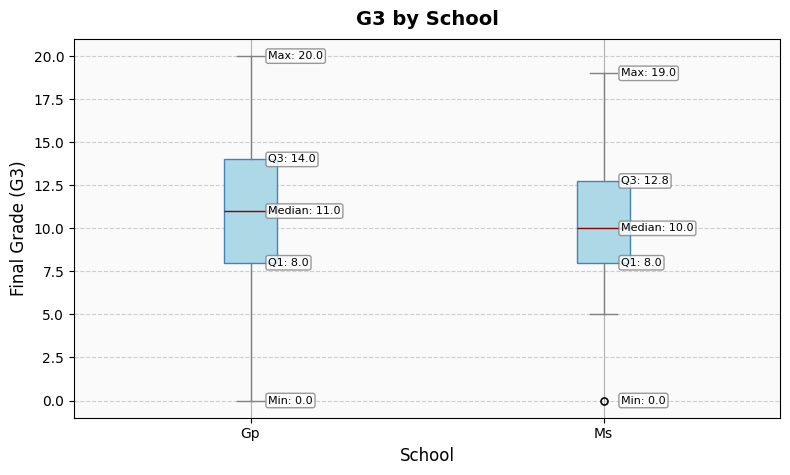

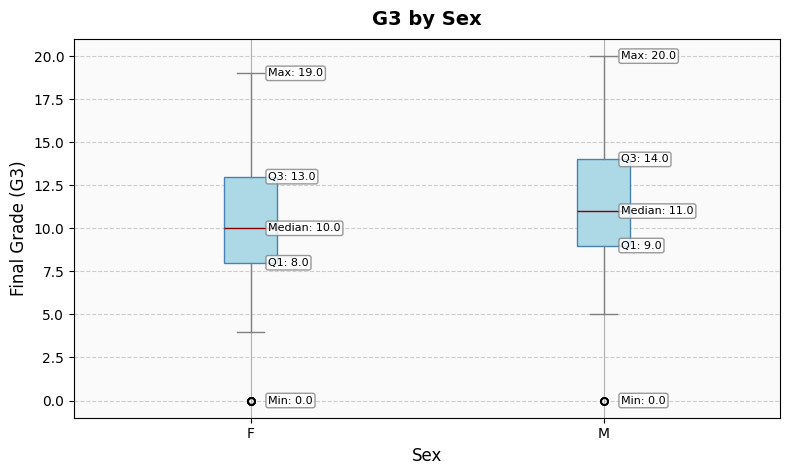

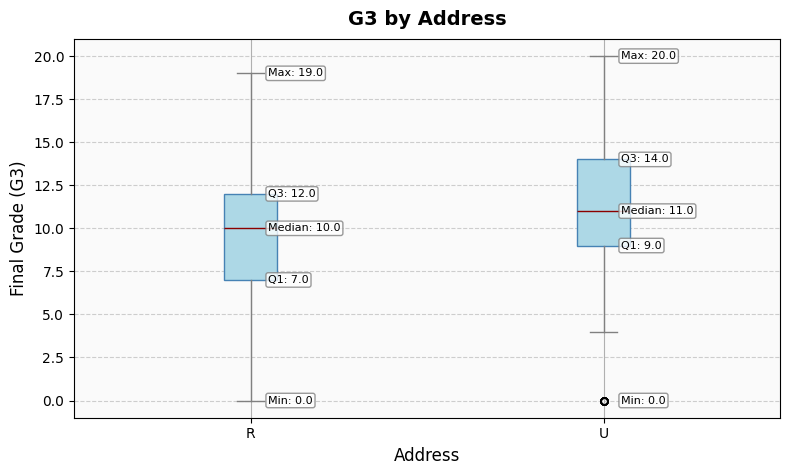

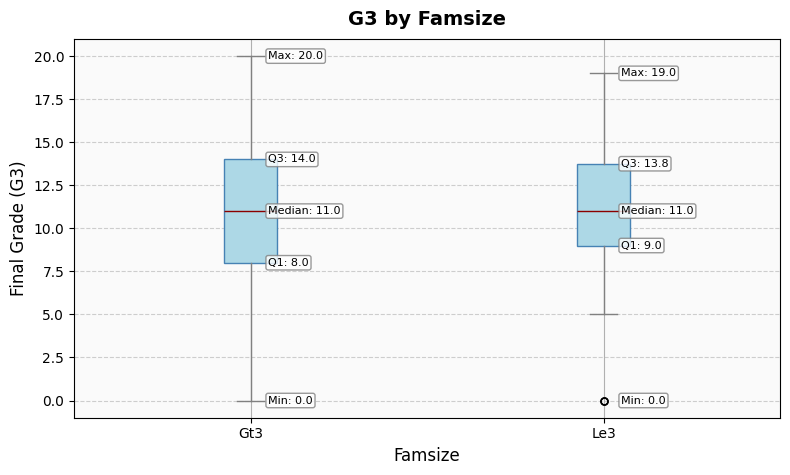

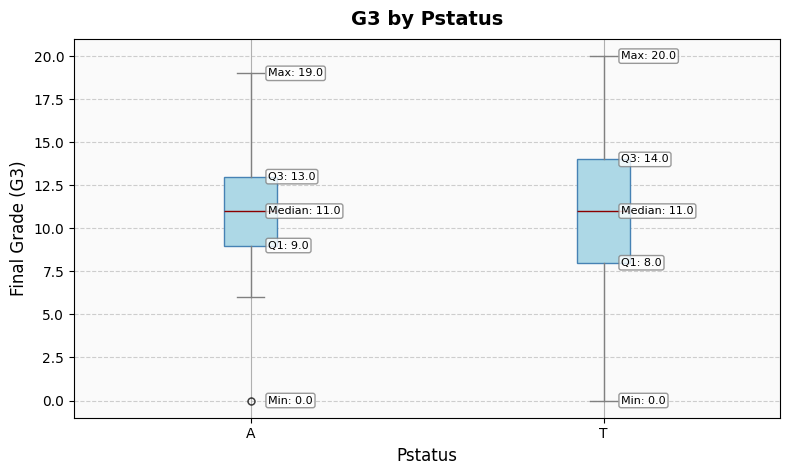

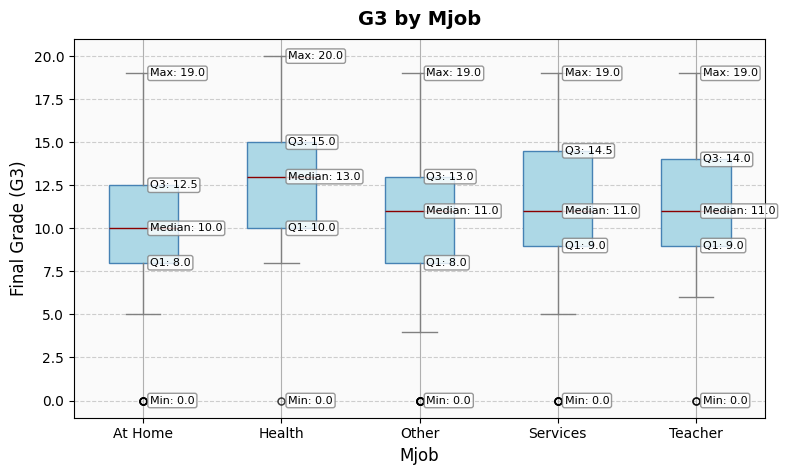

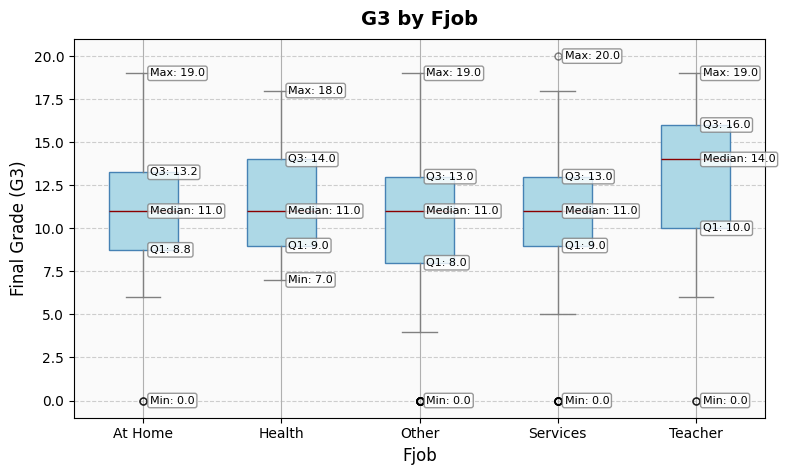

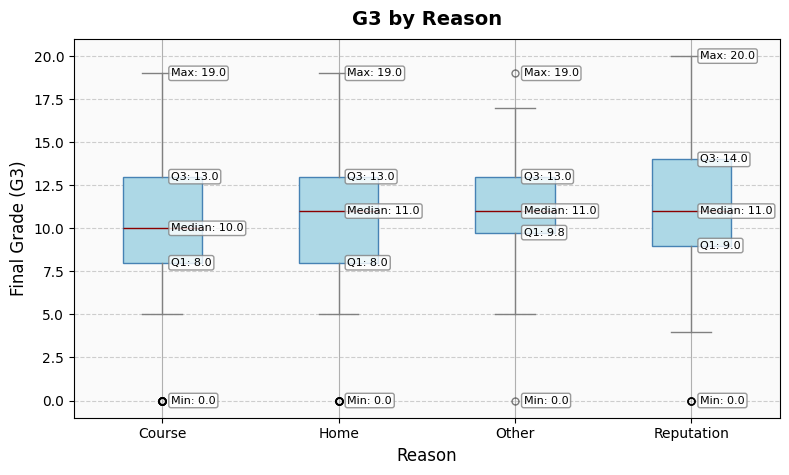

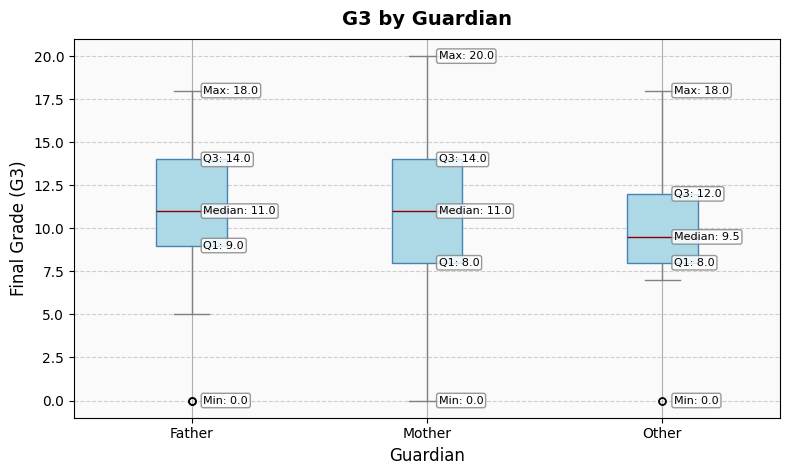

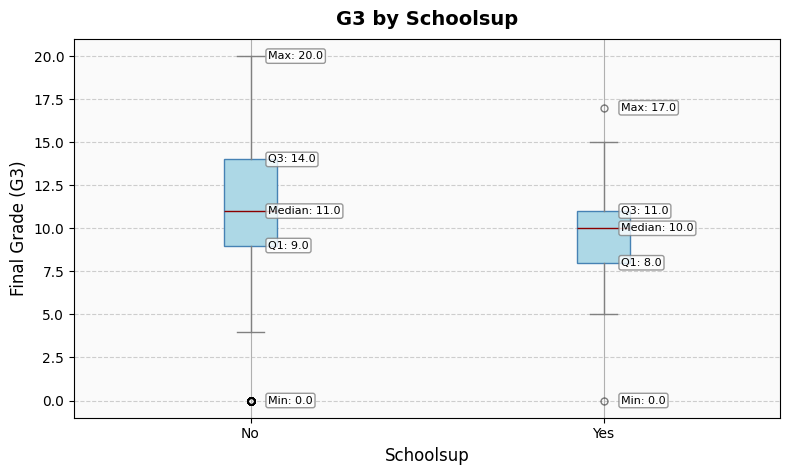

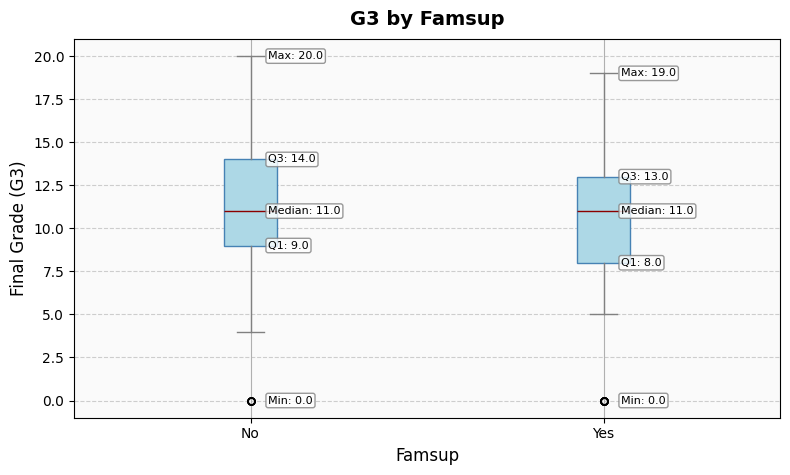

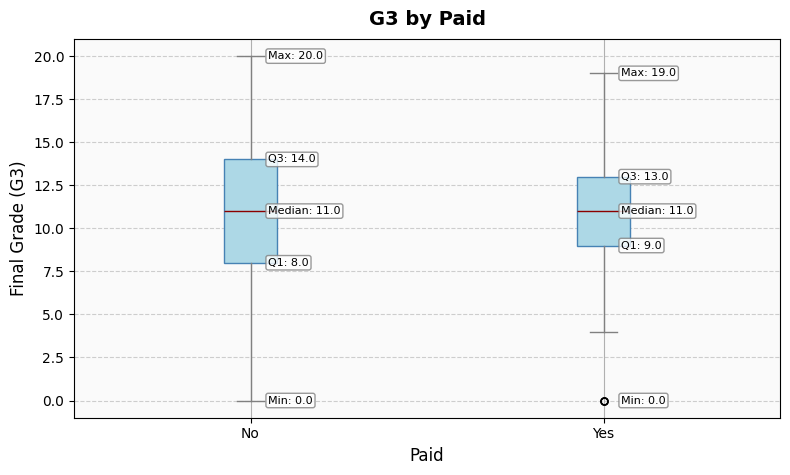

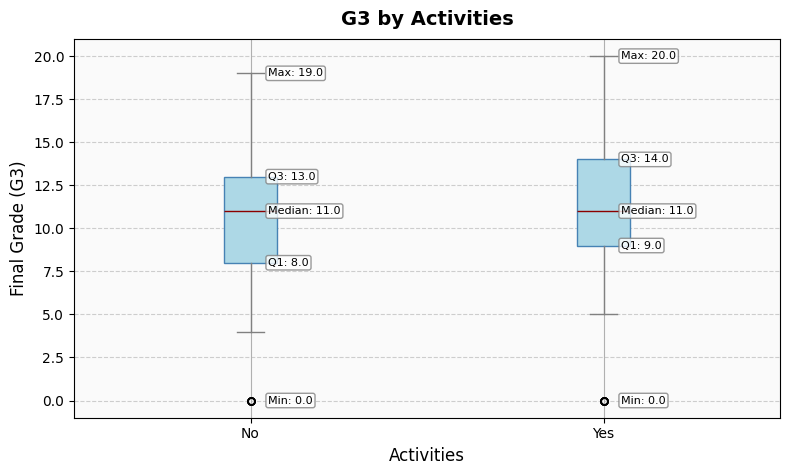

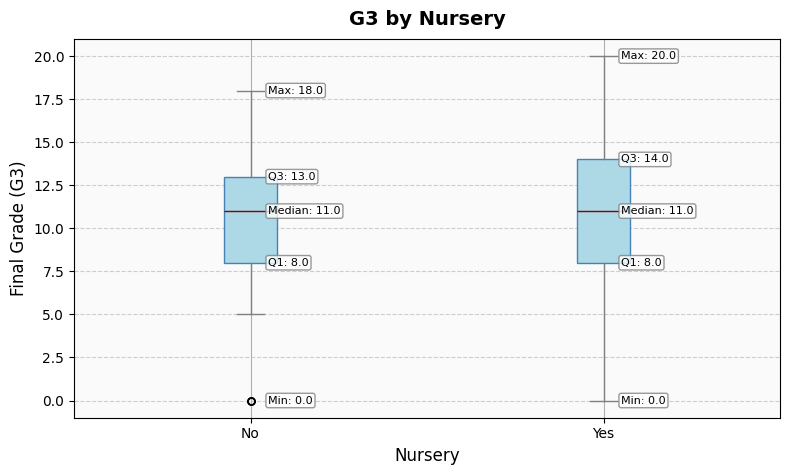

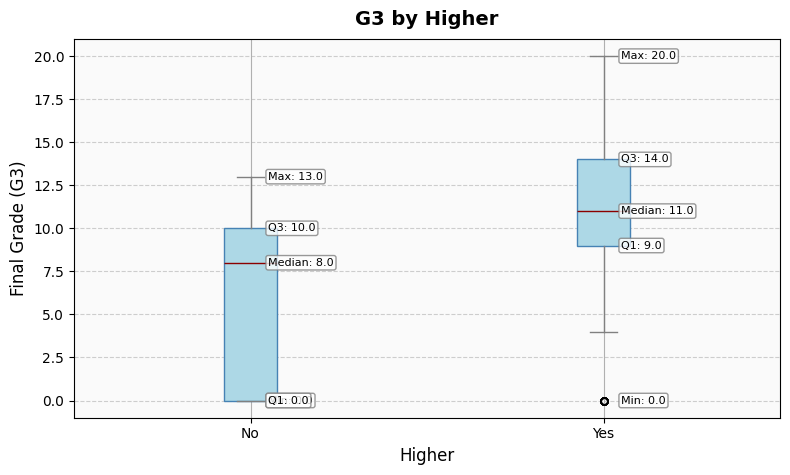

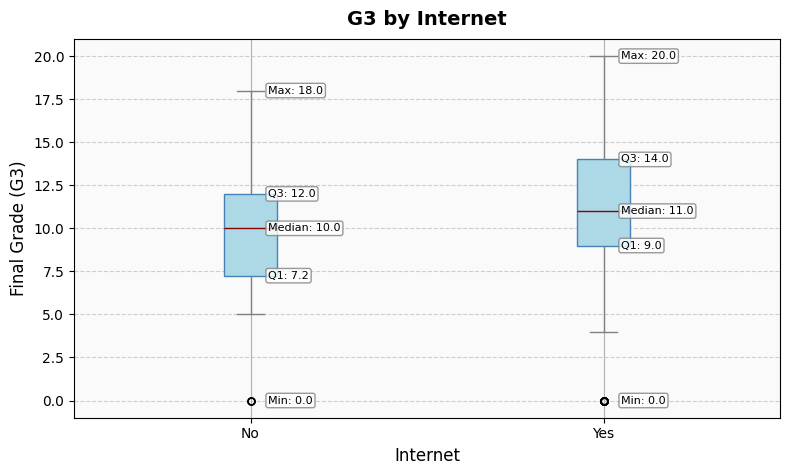

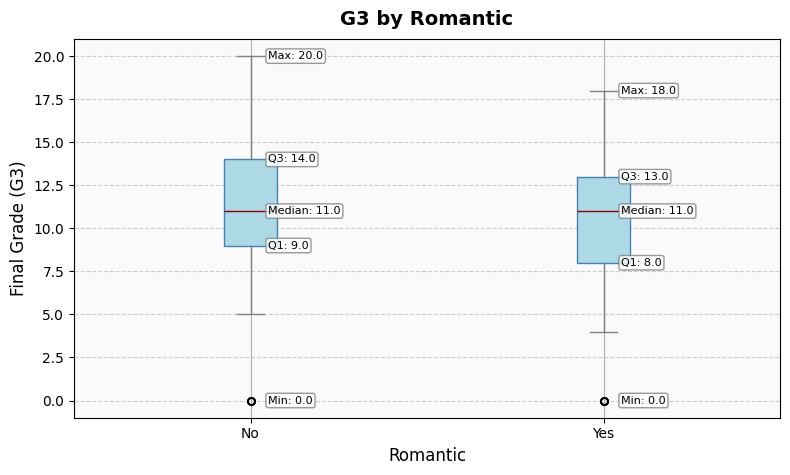

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# ‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
# ‚ïë üì¶ BOXPLOTS OF G3 GROUPED BY CATEGORICAL FEATURES (CLEANED) ‚ïë
# ‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

# Identify categorical columns
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

# Function to clean titles (e.g., "school_support" ‚Üí "School Support")
def clean_label(label):
    return str(label).replace("_", " ").title()

# Plot boxplots for each categorical column
for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    
    if len(unique_vals) < 2:
        continue  # Skip non-informative columns

    fig, ax = plt.subplots(figsize=(8, 5))

    # Boxplot setup
    df.boxplot(column="G3", by=col, ax=ax, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='steelblue'),
               medianprops=dict(color='darkred'),
               whiskerprops=dict(color='gray'),
               capprops=dict(color='gray'),
               flierprops=dict(marker='o', markersize=5, color='gray', alpha=0.5))

    # Clean title and labels
    ax.set_title(f"G3 by {clean_label(col)}", fontsize=14, fontweight='bold', pad=10)
    plt.suptitle("")
    ax.set_xlabel(clean_label(col), fontsize=12)
    ax.set_ylabel("Final Grade (G3)", fontsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.set_facecolor("#fafafa")

    # Map category values to positions (default: 1, 2, 3...)
    sorted_vals = sorted(unique_vals)
    positions = {val: i + 1 for i, val in enumerate(sorted_vals)}

    for val, pos in positions.items():
        stats = df[df[col] == val]["G3"].describe()
        labels = {
            "Min": stats["min"],
            "Q1": stats["25%"],
            "Median": stats["50%"],
            "Q3": stats["75%"],
            "Max": stats["max"]
        }

        for label, y in labels.items():
            ax.text(
                pos + 0.05, y,
                f"{label}: {y:.1f}",
                va='center', ha='left',
                fontsize=8, color='black',
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.2', alpha=0.8)
            )

    # Replace x-tick labels with cleaned versions
    ax.set_xticklabels([clean_label(val) for val in sorted_vals], fontsize=10)

    plt.tight_layout()
    plt.show()